<a href="https://colab.research.google.com/github/poojamahajan0712/Data-Science-Portfolio/blob/main/NLP/Machine%20Translation/MachineTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "tensorflow-text>=2.11"
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 77.3 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_text as tf_text
import einops
import pathlib
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense, Embedding, TimeDistributed, MultiHeadAttention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from collections import Counter

In [3]:
dataset_path = "/content/drive/MyDrive/Machine_Translation/eng_-french/eng_-french.csv"
df1 = pd.read_csv(dataset_path)
df1.tail()

,English words/sentences,French words/sentences
175616,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç..."
175617,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
175618,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
175619,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
175620,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...


In [4]:
df1.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [5]:
eng_text = df1['English words/sentences'].values
french_text = df1['French words/sentences'].values



In [6]:
eng_text[1],french_text[1] ## space before ! is encoded as \u202f

('Run!', 'Cours\u202f!')

In [7]:
import unicodedata
import re

def lower_and_split_punct(text):
    # Split accented characters (normalize to NFKD form)
    text = unicodedata.normalize('NFKD', text)

    # Convert text to lowercase
    text = text.lower()

    # Keep spaces, a to z, and select punctuation, and remove other characters like '\u202f' and numbers
    text = re.sub(r'[^ a-z.?!,¿]', '', text)

    # Add spaces around punctuation
    text = re.sub(r'([.?!,¿])', r' \1 ', text)

    # Strip extra whitespace
    text = text.strip()

    # Add [START] and [END] tokens
    text = '[START] ' + text + ' [END]'

    return text


eng_processed = [lower_and_split_punct(sentence) for sentence in eng_text]
french_processed = [lower_and_split_punct(sentence) for sentence in french_text]



In [8]:
eng_processed[0],eng_text[0],french_processed[0],french_text[0]


('[START] hi . [END]', 'Hi.', '[START] salut ! [END]', 'Salut!')

In [9]:
from sklearn.model_selection import train_test_split
X = eng_processed
Y = french_processed
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)
len(X_train),len(y_train), len(X_test), len(y_test)

(158058, 158058, 17563, 17563)

In [10]:
X_train[0], y_train[0]

('[START] i used to respect you . [END]',
 '[START] autrefois ,  je te respectais . [END]')

In [11]:
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_

#Training data
max_length_english = Max_length(X_train)
max_length_french= Max_length(y_train)

#Test data
max_length_english_test = Max_length(X_test)
max_length_french_test = Max_length(y_test)

In [12]:
max_length_english,max_length_french,max_length_english_test,max_length_french_test

(53, 64, 37, 38)

In [13]:

englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1

X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')

X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')

In [14]:

frenchTokenizer = Tokenizer()
frenchTokenizer.fit_on_texts(y_train)
Fword2index = frenchTokenizer.word_index
vocab_size_target = len(Fword2index) + 1

y_train = frenchTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_french, padding='post')

y_test = frenchTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_french_test, padding='post')

In [15]:
import pickle as pkl
vocab_size_source, vocab_size_target

with open('NMT_data.pkl','wb') as f:
  pkl.dump([X_train, y_train, X_test, y_test],f)


with open('NMT_Etokenizer.pkl','wb') as f:
  pkl.dump([vocab_size_source, Eword2index, englishTokenizer], f)

with open('NMT_Ftokenizer.pkl', 'wb') as f:
  pkl.dump([vocab_size_target, Fword2index, frenchTokenizer], f)

In [16]:

X_train[0], y_train[0]

(array([   1,    3,  246,    5, 1109,    4,    2,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([    1,  4283,     3,    36, 16433,     2,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0], dtype=int32))

In [17]:

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
vocab_size_source,vocab_size_target, max_length_english, max_length_french

In [20]:


K.clear_session()

latent_dim = 50  # Dimensionality of the latent space

# Encoder
encoder_inputs = Input(shape=(max_length_english,))
enc_emb = Embedding(vocab_size_source, latent_dim, trainable=True)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_size_target, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Multi-Head Attention Layer
multi_head_attn = MultiHeadAttention(num_heads=8, key_dim=latent_dim)
attn_out, attn_scores = multi_head_attn(query=decoder_outputs, value=encoder_outputs, return_attention_scores=True)

# Concatenate attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 53)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 53, 50)         │        696,500 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 53, 50),       │         20,200 │ embedding[0][0]        │
│                           │ (None, 50), (None,     │                │                        │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 53, 50),       │         20,200 │ lstm[0][0]             │
│                           │ (None, 50), (None,     │                │                        │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 50)       │      1,345,300 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 53, 50),       │         20,200 │ lstm_1[0][0]           │
│                           │ (None, 50), (None,     │                │                        │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 50),     │         20,200 │ embedding_1[0][0],     │
│                           │ (None, 50), (None,     │                │ lstm_2[0][1],          │
│                           │ 50)]                   │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ [(None, None, 50),     │         81,250 │ lstm_3[0][0],          │
│ (MultiHeadAttention)      │ (None, 8, None, None)] │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 100)      │              0 │ lstm_3[0][0],          │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 26906)    │      2,717,506 │ concatenate[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,921,356 (18.77 MB)

 Trainable params: 4,921,356 (18.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
plot_model(model, to_file='train_model.png', show_shapes=True)

In [21]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [23]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:],
                    epochs=50,
                    callbacks=[es],
                    batch_size=512,
                    validation_data = ([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))


Epoch 1/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.8687 - loss: 2.3424 - val_accuracy: 0.8325 - val_loss: 1.1870
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.9011 - loss: 0.7109 - val_accuracy: 0.8347 - val_loss: 1.1652
Epoch 3/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.9017 - loss: 0.6941 - val_accuracy: 0.8350 - val_loss: 1.1322
Epoch 4/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.9028 - loss: 0.6741 - val_accuracy: 0.8375 - val_loss: 1.0997
Epoch 5/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.9037 - loss: 0.6575 - val_accuracy: 0.8390 - val_loss: 1.0766
Epoch 6/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.9045 - loss: 0.6444 - val_accuracy: 0.8406 - val_loss: 1.0631
Epoch 7/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.9052 - loss: 0.6334 - val_accuracy: 0.8412 - val_loss: 1.0403
Epoch 8/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.9061 - loss: 0.6223 - val_accu

In [31]:

model_json = model.to_json()
with open("/content/drive/MyDrive/Machine_Translation/saved_model/NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/Machine_Translation/saved_model/NMT_model_weight.weights.h5")
print("Saved model to disk")

Saved model to disk


In [32]:
from tensorflow.keras.models import Model,load_model, model_from_json
# loading the model architecture and asigning the weights
json_file = open("/content/drive/MyDrive/Machine_Translation/saved_model/NMT_model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json)
# load weights into new model
model_loaded.load_weights("/content/drive/MyDrive/Machine_Translation/saved_model/NMT_model_weight.weights.h5")

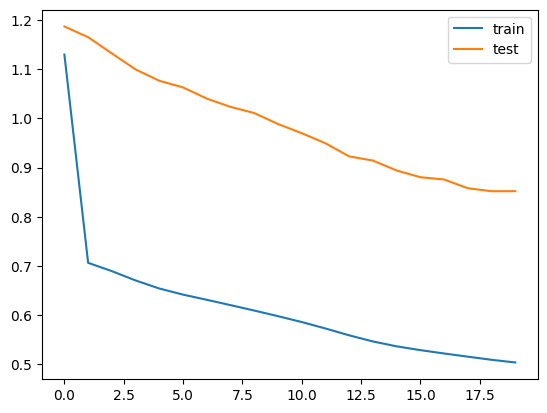

In [33]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [35]:

with open('/content/drive/MyDrive/Machine_Translation/data_pkl/NMT_Etokenizer.pkl','rb') as f:
  vocab_size_source, Eword2index, englishTokenizer = pkl.load(f)

with open('/content/drive/MyDrive/Machine_Translation/data_pkl/NMT_Mtokenizer.pkl', 'rb') as f:
  vocab_size_target, Mword2index, marathiTokenizer = pkl.load(f)

with open('/content/drive/MyDrive/Machine_Translation/data_pkl/NMT_data.pkl','rb') as f:
  X_train, y_train, X_test, y_test = pkl.load(f)

In [37]:
Eindex2word = englishTokenizer.index_word
Findex2word = frenchTokenizer.index_word

In [38]:

model_loaded.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 53)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 53, 50)         │        696,500 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 53, 50),       │         20,200 │ embedding[0][0]        │
│                           │ (None, 50), (None,     │                │                        │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 53, 50),       │         20,200 │ lstm[0][0]             │
│                           │ (None, 50), (None,     │                │                        │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 50)       │      1,345,300 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 53, 50),       │         20,200 │ lstm_1[0][0]           │
│                           │ (None, 50), (None,     │                │                        │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 50),     │         20,200 │ embedding_1[0][0],     │
│                           │ (None, 50), (None,     │                │ lstm_2[0][1],          │
│                           │ 50)]                   │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ [(None, None, 50),     │         81,250 │ lstm_3[0][0],          │
│ (MultiHeadAttention)      │ (None, 8, None, None)] │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 100)      │              0 │ lstm_3[0][0],          │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 26906)    │      2,717,506 │ concatenate[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,842,714 (37.55 MB)

 Trainable params: 4,921,356 (18.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,921,358 (18.77 MB)

In [59]:
latent_dim=50
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs

print(encoder_outputs.shape)

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(53,latent_dim))

# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output

print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]

dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
multi_head_attn_layer = model_loaded.layers[8]
attn_out_inf, attn_scores_inf = multi_head_attn_layer(query=decoder_outputs2, value=decoder_hidden_state_input, return_attention_scores=True)


concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


(None, 53, 50)
(None, None)


In [60]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = Fword2index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
          sampled_token = Findex2word[sampled_token_index]

          if(sampled_token!='end'):
              decoded_sentence += ' '+sampled_token

              # Exit condition: either hit max length or find stop word.
              if (sampled_token == 'end' or len(decoded_sentence.split()) >= (26-1)):
                  stop_condition = True

          # Update the target sequence (of length 1).
          target_seq = np.zeros((1,1))
          target_seq[0, 0] = sampled_token_index

          # Update internal states
          e_h, e_c = h, c

    return decoded_sentence



In [61]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Mword2index['start']) and i!=Mword2index['end']):
        newString=newString+Findex2word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Eindex2word[i]+' '
    return newString

In [62]:
for i in range(10):

  print("Review:",seq2text(X_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print("Predicted summary:",decode_sequence(X_test[i].reshape(1,53)))
  print("\n")

Review: start can i talk to you for a minute end 
Original summary: je peux te parler une minute 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted summary:  je ne veux pas que tu veux que tu veux etre


Review: start youre opportunistic end 
Original summary: vous etes un opportuniste 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 